In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os


In [2]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(100),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [4]:
! git clone https://github.com/Lauriane-cloud/photos_cirses.git

Cloning into 'photos_cirses'...
remote: Enumerating objects: 20718, done.
remote: Total 20718 (delta 0), reused 0 (delta 0), pack-reused 20718
Receiving objects: 100% (20718/20718), 154.02 MiB | 28.55 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (21483/21483), done.


In [5]:
%cd photos_cirses/cirses-pos-neg.v1i.folder/

/content/photos_cirses/cirses-pos-neg.v1i.folder


In [6]:
# Define the data directory
data_dir = '.'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets

In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 6064, 'val': 1080}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


['Negative', 'Positive']

In [ ]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


In [ ]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print('Epoch', epoch)
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")


KeyboardInterrupt: 

In [ ]:

# Save the model
torch.save(model.state_dict(), 'classification_model.pth')


In [ ]:
%cd ..

/content/photos_cirses


In [ ]:
! git pull

remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), 41.44 MiB | 7.77 MiB/s, done.
From https://github.com/Lauriane-cloud/photos_cirses
   5f9355e1..bedd3f63  main       -> origin/main
Updating 5f9355e1..bedd3f63
Fast-forward
 classification_model.pth | Bin 0 -> 46838500 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 classification_model.pth


# Classification on Unseen Image

To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference.

In [9]:
%pwd

'/content/photos_cirses/cirses-pos-neg.v1i.folder'

In [10]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('../classification_model.pth', map_location=torch.device('cpu')))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [14]:
from torchvision.transforms import ToTensor
# Load and preprocess the unseen image
image_path = './test/Positive/DJI_0108_2200_3800_jpg.rf.ad74a5f5ec39cbde53caa5da4edf28a1.jpg'  # Replace with the path to your image
image = Image.open(image_path)
# preprocess = transforms.Compose([
#    transforms.Resize(100),
#    transforms.CenterCrop(100),
#    transforms.ToTensor(),
#    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
preprocess = transforms.Compose([
    transforms.Resize(100),
   transforms.CenterCrop(100),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
 ])

input_tensor = preprocess(image)
# input_tensor = ToTensor(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


In [ ]:
print(input_tensor)

tensor([[[-0.0972,  0.4337,  1.0159,  ..., -0.9192, -0.9192, -0.8507],
         [-0.0458,  0.5536,  0.9817,  ..., -0.7479, -0.8164, -0.8678],
         [ 0.2282,  0.9303,  1.2899,  ..., -0.7993, -0.9534, -1.0390],
         ...,
         [ 0.8618,  0.9817,  0.3138,  ..., -0.2171, -0.1828, -0.0801],
         [ 0.7762,  0.9988,  0.4337,  ...,  0.1939, -0.0116, -0.1143],
         [ 0.6221,  0.9474,  0.4851,  ...,  0.2624, -0.0972, -0.3027]],

        [[-0.5651, -0.0224,  0.5728,  ..., -1.1779, -1.1779, -1.1078],
         [-0.5126,  0.1001,  0.5378,  ..., -0.9503, -1.0728, -1.0728],
         [-0.2325,  0.4853,  0.8529,  ..., -0.9678, -1.1604, -1.2129],
         ...,
         [ 0.6954,  0.8179,  0.0476,  ..., -0.3025, -0.2675, -0.1625],
         [ 0.6078,  0.8354,  0.1702,  ...,  0.1176, -0.0924, -0.1975],
         [ 0.4503,  0.7829,  0.2227,  ...,  0.1877, -0.1800, -0.3901]],

        [[-0.8284, -0.2881,  0.3045,  ..., -1.3164, -1.3164, -1.2467],
         [-0.7761, -0.1661,  0.2696,  ..., -1

Perform inference using the model:

In [15]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)
print(output.shape)
# print(output)
# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['Negative', 'Positive']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


torch.Size([1, 1000])
The predicted class is: Positive


In [16]:

def getSaliency(model,img,label):
  model.zero_grad()
  img = img.to(device)
  # print(img)
  img.requires_grad = True    # ajout du gradient sur l'image elle-même
                                # idée: + gd gradient = + fort impact sur la décision
  img.grad = None
  outputs = nn.Softmax(dim=1)(model(img.unsqueeze(0)))    # ATTENTION, le softmax est dans la loss, pas dans le réseau
                                                            # => il faut le remettre à la main pour que ça marche
  # print(outputs)
  output=outputs[0,label]     # focalisation sur la vérité terrain
  # print(output)
  output.backward()           # calcul des gradients associés à cette classe seulement
  sal=img.grad.abs()          # récupération du gradient sur l'image (+abs)
  # print(sal)
  if sal.dim()>2:
      sal=torch.max(sal,dim=0)[0]

  fig=plt.figure(figsize=(8, 8))
  fig.add_subplot(1, 2, 1)
  plt.imshow(img.detach().squeeze().permute(1, 2, 0).cpu().numpy(),cmap="gray")
  fig.add_subplot(1, 2, 2)
  plt.imshow(sal.to('cpu'),cmap="seismic",interpolation="bilinear")
  return sal



In [17]:
import torch
import numpy as np
from PIL import Image

saliency_map = getSaliency(model,input_tensor, 1)


NameError: name 'device' is not defined

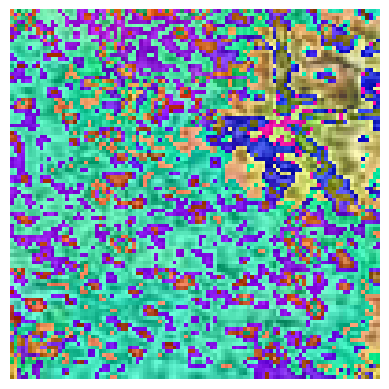

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Supposons que img_tensor est votre tenseur PyTorch représentant une image
# Assurez-vous que les valeurs du tenseur sont comprises entre 0 et 1
# Si nécessaire, vous pouvez utiliser des transformations pour normaliser le tenseur
transform = transforms.ToPILImage()  # Transformer le tenseur en une image PIL
img_pil = transform(input_tensor)

# Afficher l'image à l'aide de Matplotlib
plt.imshow(img_pil)
plt.axis('off')  # Pour supprimer les axes
plt.show()


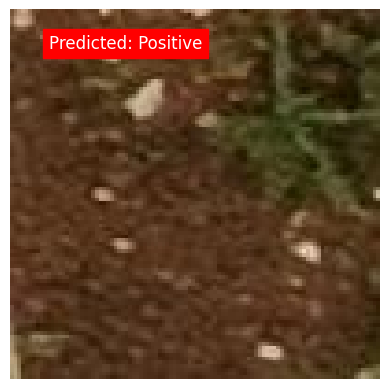

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

In [ ]:
def getSaliency(model,img,label):
    model.eval()
    #img = img.to(device)
    img.requires_grad = True    # ajout du gradient sur l'image elle-même
                                # idée: + gd gradient = + fort impact sur la décision
    img.grad = None
    outputs = nn.Softmax(dim=1)(model(img.unsqueeze(0)))    # ATTENTION, le softmax est dans la loss, pas dans le réseau
                                                            # => il faut le remettre à la main pour que ça marche
    _, predicted = torch.max(outputs.data, 1)
    output=outputs[0,label]     # focalisation sur la vérité terrain
    output.backward()           # calcul des gradients associés à cette classe seulement
    sal=img.grad.abs()          # récupération du gradient sur l'image (+abs)
    if sal.dim()>2:
        sal=torch.max(sal,dim=0)[0]

    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img.detach().cpu().permute(1,2,0),cmap="gray")

    fig.add_subplot(1, 2, 2)
    plt.imshow(sal.to('cpu'),cmap="seismic",interpolation="bilinear")

    plt.show()

In [ ]:
getSaliency(model, image, '1')

AttributeError: 'numpy.ndarray' object has no attribute 'requires_grad'